In [3]:
from transformers import AutoModel, AutoTokenizer
import torch
import json
import os
import tqdm
import decord
from decord import VideoReader
decord.bridge.set_bridge("torch")
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
import math
from typing import Dict, Optional, Sequence, List

def ceil_time_by_fps(time: float, fps: int, min_time: float, max_time: float):
    return min(max(math.ceil(time * fps) / fps, min_time), max_time)

class AnnotationLoader:
    def __init__(self, train_path, val_path, origin_path, EGO4D_JSON_PATH):
        self.train_data = json.load(open(train_path))
        self.val_data = json.load(open(val_path))
        self.data = {**self.train_data, **self.val_data}
        
        self.origin_narration = json.load(open(origin_path))['videos']
        
        meta_data = json.load(open(EGO4D_JSON_PATH))['videos']
        self.meta_data = {}
        for meta_d in meta_data:
            self.meta_data[meta_d['video_uid']] = meta_d
        
    def get_data(self):
        return self.data
    
    def get_origin_narration(self):
        return self.origin_narration
    
    def get_meta_data(self):
        return self.meta_data

class BetaAlphaCalculator:
    def __init__(self, data, alpha=4.9):
        self.data = data
        self.beta_map = {}
        self.alpha = alpha
    
    def compute_beta(self):
        for video_uid, annotation_uid_narrations in self.data.items():
            for annotation_uid, narrations in annotation_uid_narrations.items():
                if len(narrations) == 0:
                    continue
                total_time = 0
                for i in range(len(narrations) - 1):
                    total_time += narrations[i+1]['time'] - narrations[i]['time']
                self.beta_map[annotation_uid] = total_time / len(narrations)
    
    def get_beta_map(self):
        return self.beta_map
    
    def get_alpha(self):
        return self.alpha
    
    
    
train_path = '/root/videollm-online/datasets/ego4d/v2/annotations/refined_narration_stream_train.json'
val_path = '/root/videollm-online/datasets/ego4d/v2/annotations/refined_narration_stream_val.json'
origin_path = '/root/videollm-online/datasets/ego4d/v2/annotations/all_narrations_redacted.json'
EGO4D_JSON_PATH = "/root/videollm-online/datasets/ego4d/ego4d.json"
fileter_data_path = '/root/videollm-online/datasets/ego4d/v2/annotations/filtered_data.json'
video_root = '/root/videollm-online/datasets/ego4d/v2/full_scale_2fps'
video2scene = json.load(open('/root/videollm-online/data/preprocess/metafile/video2scene.json'))
video_uid_list = open('/root/videollm-online/data/preprocess/metafile/major2scene_case.txt').read().split('\n')
video_uid_list = os.listdir(video_root)
video_uid_list = [file.split('.')[0] for file in video_uid_list]
alpha = 4.9
device = 'cuda:7'

annotation_loader = AnnotationLoader(train_path, val_path, origin_path, EGO4D_JSON_PATH)
data = annotation_loader.get_data()
origin_data = annotation_loader.get_origin_narration()
meta_data = annotation_loader.get_meta_data()
filtered_data = json.load(open(fileter_data_path))

beta_alpha_calculator = BetaAlphaCalculator(data, alpha)
beta_alpha_calculator.compute_beta()
beta_map = beta_alpha_calculator.get_beta_map()
alpha = beta_alpha_calculator.get_alpha()


In [9]:
class VideoProcessor:
    def __init__(self, data, beta_map, alpha, video_root, frame_fps=2, device='cuda:4'):
        self.data = data
        self.beta_map = beta_map
        self.alpha = alpha
        self.video_root = video_root
        self.frame_fps = frame_fps
        
        from siglip import visionTextAligner
        self.aliger = visionTextAligner(device=device)
    
    def action2clip(self, path, clip_idx, action_idx):
        annotation_uids = list(self.data[path].keys())
        clip_id = annotation_uids[clip_idx]
        narration = self.data[path][clip_id][action_idx]
        stamp_time = narration['time']
        beta = self.beta_map.get(clip_id, 0)
        start_time = stamp_time - beta / (2 * self.alpha)
        end_time = stamp_time + beta / (2 * self.alpha)
        return stamp_time, start_time, end_time, clip_id
    
    def load_video(self, path):
        video_path = os.path.join(self.video_root, f"{path}.mp4")
        vr = VideoReader(video_path)
        return vr

    def load_action_clip(self,vr, path, clip_idx, action_idx, is_stereo=False):
        stamp_time, start_time, end_time, clip_id = self.action2clip(path, clip_idx, action_idx)
        narration = self.data[path][clip_id][action_idx]['text']
        
        start_frame = int(ceil_time_by_fps(start_time, self.frame_fps, 0, (vr._num_frame-1) / self.frame_fps) * self.frame_fps)
        end_frame = int(ceil_time_by_fps(end_time, self.frame_fps, 0, (vr._num_frame-1) / self.frame_fps)* self.frame_fps) + 1
        
        try:
            load_range = range(start_frame, end_frame)
            frames = vr.get_batch(load_range)
        except:
            breakpoint()
        
        if is_stereo:
            frames = frames[:, :, :frames.shape[2] // 2, :]    
        if len(frames.shape) == 3:
            print(path)
        try:
            simi, simi_m = self.aliger.vision_simi(frames, return_m=True)
        except:
            breakpoint()
        
        frames = [Image.fromarray(frame.numpy().astype('uint8')) for frame in frames]
        
        return narration, frames, stamp_time, start_time, end_time, load_range, simi, simi_m
    
video_processor = VideoProcessor(data, beta_map, alpha, video_root, device=device)

In [12]:
for path in tqdm.tqdm(video_uid_list):
    
    # fileter_data
    if path not in filtered_data.keys():
        continue
    
    output_json = {}
    output_json[path] = {}
    annotation_uid_narrations = data[path]
    
    # is_stereo
    is_stereo = meta_data[path]['is_stereo']
    if not is_stereo:
        continue
    print(path)
    # load video
    vr = video_processor.load_video(path)
    
    for clip_idx, (annotation_uid, narrations) in enumerate(annotation_uid_narrations.items()):

        # fileter_data
        if annotation_uid not in filtered_data[path].keys():
            continue

        for action_idx, narration in enumerate(narrations):
            
            action_narration, frames, stamp_time, start_time, end_time, load_range, simi, simi_m = video_processor.load_action_clip(vr, path, clip_idx, action_idx, is_stereo)
            break
        break

  0%|          | 0/478 [00:00<?, ?it/s]

7d9d151b-3985-403e-8b47-195c3fc7d278


 50%|████▉     | 237/478 [00:00<00:00, 641.52it/s]

6d35114b-84f3-4369-a045-4ff2fa04f40f


100%|██████████| 478/478 [00:01<00:00, 452.09it/s]


/tmp/ipykernel_1949755/2919165881.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  it = torch.load('/2022233235/datasets/ESTP_IT/estp_processed_True_0.00_1.pth')


60116

High Frame Numbers Statistics:
Min: 1.00
Max: 60.00
Mean: 3.21
Median: 2.00
25th percentile: 1.00
75th percentile: 4.00
more than 100: 0
more than 1000: 0

Answer Numbers Statistics:
Min: 1.00
Max: 60.00
Mean: 3.22
Median: 2.00
25th percentile: 1.00
75th percentile: 4.00
more than 100: 0
more than 1000: 0

Frame Numbers Statistics:
Min: 1.00
Max: 1196.00
Mean: 225.07
Median: 171.00
25th percentile: 53.00
75th percentile: 378.00
more than 100: 38179
more than 1000: 91

Frame Numbers Before Query Statistics:
Min: 1.00
Max: 1.00
Mean: 1.00
Median: 1.00
25th percentile: 1.00
75th percentile: 1.00
more than 100: 0
more than 1000: 0

Response Clip Numbers Statistics:
Min: 0.00
Max: 1.86
Mean: 0.21
Median: 0.08
25th percentile: 0.03
75th percentile: 0.26
more than 100: 0
more than 1000: 0

Response Clip Lengths Statistics:
Min: 1.00
Max: 50.00
Mean: 8.90
Median: 3.00
25th percentile: 2.00
75th percentile: 8.00
more than 100: 0
more than 1000: 0

Distance Between Responses Statistics:
M

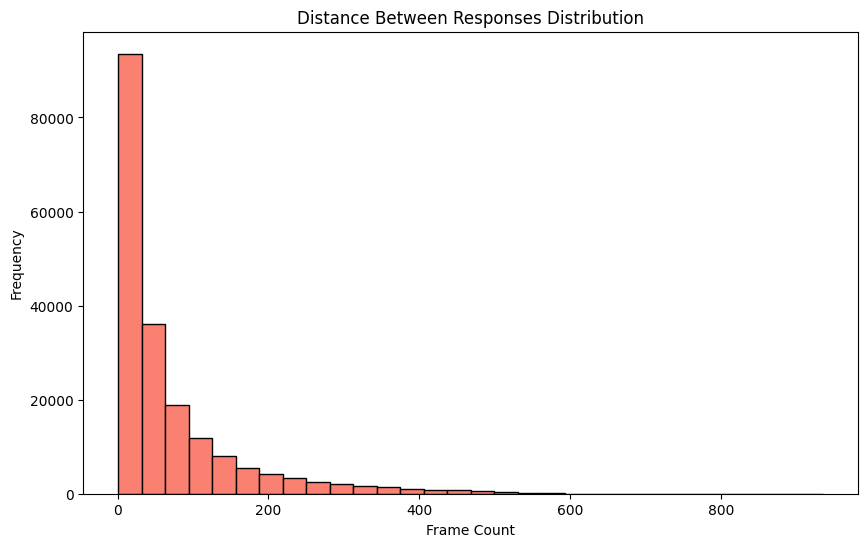

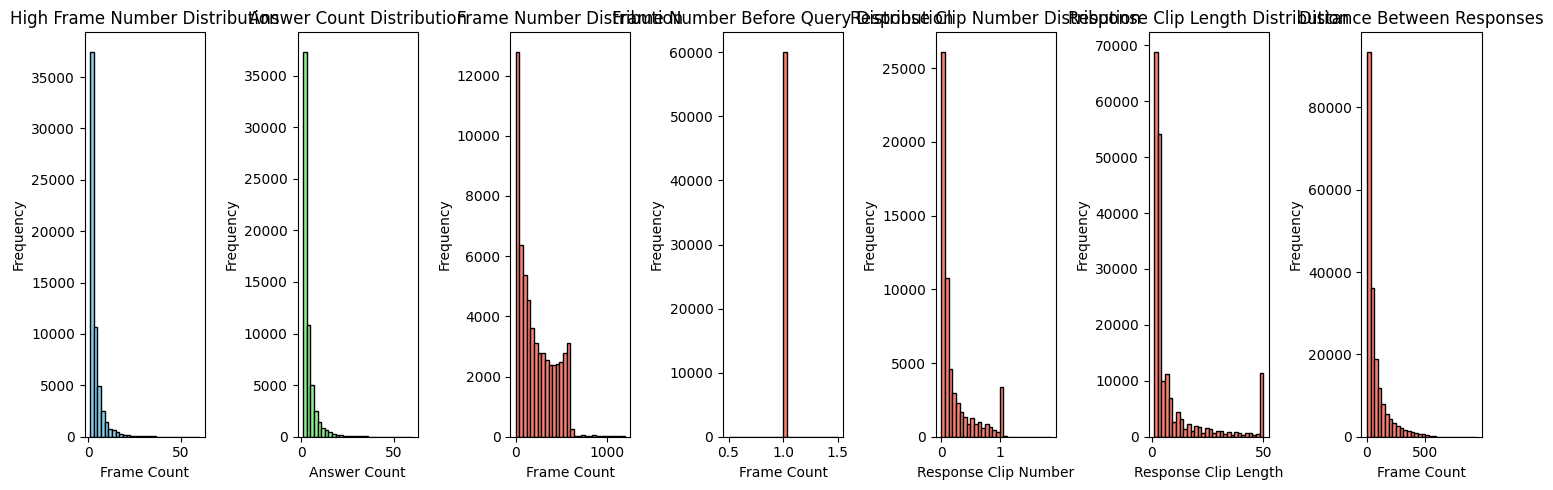

In [43]:
import torch
import json
it = torch.load('/2022233235/datasets/ESTP_IT/estp_processed_True_0.00_1.pth')
# it = torch.load('/2022233235/videollm-online/estp_bench_sq_processed_True_0.0_1.pth')
# it = torch.load('/2022233235/datasets/ESTP_IT/estp_cqa_with_time_processed_True_0.00_1.pth')

print(len(it))
# print(json.dumps(it[0]['conversation'], indent=4))

high_frame_numbers = []
answer_numbers = []
frame_numbers = []
frame_number_before_query_numbers = []
response_clip_number = []
response_clip_length = []
dis_pre_response = []

for qa in it:
    high_frame_number = 0
    answer_number = 0
    frame_number = 0
    is_query = False
    frame_number_before_query = 0
    # if qa['Task Type'] != 'Action Reasoning':
    #     continue
    for conv in qa['conversation']:
        if conv['role'] == 'user':
            is_query = True
        if conv['role'] == 'assistant':
            answer_number += 1 if is_query else 0
        elif conv['role'] == 'stream': 
            if is_query:
                frame_number += conv['num_frames']
                dis_pre_response.append(conv['num_frames'])
            else:
                frame_number_before_query += conv['num_frames']
        elif conv['role'] == 'stream_high':
            if is_query:
                high_frame_number += conv['num_frames']
            
    high_frame_numbers.append(high_frame_number)
    answer_numbers.append(answer_number)
    frame_numbers.append(frame_number)
    frame_number_before_query_numbers.append(frame_number_before_query)
    
    this_turn_response_clip_number = 0
    for response in qa['reponse_clip']:
        this_turn_response_clip_number += response[1] - response[0]
        response_clip_length.append(response[1] - response[0])
    response_clip_number.append(this_turn_response_clip_number / (frame_number + frame_number_before_query))
    
    # if answer_number > 100:
    #     print(frame_number)
    #     print(this_turn_response_clip_number)
    #     print(json.dumps(qa['conversation'], indent=4))




import numpy as np
    
def print_stats(name, data):
    print(f"\n{name} Statistics:")
    print(f"Min: {np.min(data):.2f}")
    print(f"Max: {np.max(data):.2f}")
    print(f"Mean: {np.mean(data):.2f}")
    print(f"Median: {np.median(data):.2f}")
    print(f"25th percentile: {np.percentile(data, 25):.2f}")
    print(f"75th percentile: {np.percentile(data, 75):.2f}")
    
    print(f'more than 100: {len([f for f in data if f > 100])}')
    print(f'more than 1000: {len([f for f in data if f > 1000])}')

print_stats("High Frame Numbers", high_frame_numbers)
print_stats("Answer Numbers", answer_numbers)
print_stats("Frame Numbers", frame_numbers)
print_stats("Frame Numbers Before Query", frame_number_before_query_numbers)
print_stats("Response Clip Numbers", response_clip_number)
print_stats("Response Clip Lengths", response_clip_length)
print_stats("Distance Between Responses", dis_pre_response)

plt.figure(figsize=(10, 6))
plt.hist(dis_pre_response, bins=30, color='salmon', edgecolor='black')
plt.title('Distance Between Responses Distribution')
plt.xlabel('Frame Count')
plt.ylabel('Frequency')
plt.show()

from matplotlib import pyplot as plt
# 创建图形和坐标轴
plt.figure(figsize=(15, 5))

# Plot histograms
plt.subplot(171)
plt.hist(high_frame_numbers, bins=30, color='skyblue', edgecolor='black')
plt.title('High Frame Number Distribution')
plt.xlabel('Frame Count')
plt.ylabel('Frequency')

plt.subplot(172)
plt.hist(answer_numbers, bins=30, color='lightgreen', edgecolor='black')
plt.title('Answer Count Distribution')
plt.xlabel('Answer Count')
plt.ylabel('Frequency')

plt.subplot(173)
plt.hist(frame_numbers, bins=30, color='salmon', edgecolor='black')
plt.title('Frame Number Distribution')
plt.xlabel('Frame Count')
plt.ylabel('Frequency')

plt.subplot(174)
plt.hist(frame_number_before_query_numbers, bins=30, color='salmon', edgecolor='black')
plt.title('Frame Number Before Query Distribution')
plt.xlabel('Frame Count')
plt.ylabel('Frequency')

plt.subplot(175)
plt.hist(response_clip_number, bins=30, color='salmon', edgecolor='black')
plt.title('Response Clip Number Distribution')
plt.xlabel('Response Clip Number')
plt.ylabel('Frequency')

plt.subplot(176)
plt.hist(response_clip_length, bins=30, color='salmon', edgecolor='black')
plt.title('Response Clip Length Distribution')
plt.xlabel('Response Clip Length')
plt.ylabel('Frequency')

plt.subplot(177)
plt.hist(dis_pre_response, bins=30, color='salmon', edgecolor='black')
plt.title('Distance Between Responses')
plt.xlabel('Frame Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [3]:
import json

data = json.load(open('/2022233235/videollm-online/estp.json'))

for k,v in data.items():
    for kk, vv in v.items():
        for qa in vv:
            for conv in qa['conversation']:
                conv['role'] = "assistant"
            

with open('/2022233235/videollm-online/estp_new.json', 'w') as f:
    json.dump(data, f, indent=4)

In [1]:
import torch

data = torch.load('/2022233235/videollm-online/estp_bench_sq_processed_True_0.0_1.pth')

print(data[-1])


{'conversation': [{'role': 'stream', 'num_frames': 1, 'learn': 0}, {'role': 'stream_high', 'num_frames': 1, 'learn': False}, {'role': 'user', 'content': 'Can you remind me when the person in yellow changes position relative to me?', 'time': 106.04745034394007, 'fps_time': 106.5}, {'role': 'stream', 'num_frames': 32, 'learn': True}, {'role': 'stream_high', 'num_frames': 1, 'learn': True}, {'role': 'assistant', 'content': 'The person in yellow changes position relative to you.', 'time': 122.10355980937581, 'fps_time': 122.5, 'learn': True}], 'load_ranges': {'datasets/ego4d/full_scale_2fps_max384/5a10fa29-fd9d-4d5f-baf3-d1bdffb77e4a.mp4': range(213, 246)}, 'load_frame_high': {'datasets/ego4d/full_scale_2fps_max384/5a10fa29-fd9d-4d5f-baf3-d1bdffb77e4a.mp4': [213, 245]}, 'reponse_clip': [(24, 33)]}


/tmp/ipykernel_2286907/3800628949.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/2022233235/videollm-online/estp_bench_sq_processed_True_0.0_1.pth')

In [9]:
import torch
import json
data = torch.load('/2022233235/videollm-online/estp_bench_sq_processed_True_high_5.pth')
print((data[0]['load_ranges']))
print(json.dumps(data[0]['conversation'], indent=4))
print(json.dumps(data[0]['reponse_clip'], indent=4))


{'datasets/ego4d/full_scale_2fps_max384/200a8f32-c44a-463d-ba39-0190a0bddf7a.mp4': range(2147, 2763)}
[
    {
        "role": "stream",
        "num_frames": 1,
        "learn": 0
    },
    {
        "role": "stream_high",
        "num_frames": 1,
        "learn": false
    },
    {
        "role": "user",
        "content": "Can you remind me what the white plastic object being handled is?",
        "time": 1073.5,
        "fps_time": 1073.5
    },
    {
        "role": "stream",
        "num_frames": 5,
        "learn": true
    },
    {
        "role": "stream_high",
        "num_frames": 1,
        "learn": true
    },
    {
        "role": "assistant",
        "content": "The white plastic object being handled is a container filled with soil or organic matter, possibly for gardening purposes.",
        "time": 1075.9406868855976,
        "fps_time": 1076.0,
        "learn": true
    },
    {
        "role": "stream",
        "num_frames": 8,
        "learn": true
    },
    {
   

/tmp/ipykernel_2286907/3616641506.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/2022233235/videollm-online/estp_bench_sq_processed_True_high_5.pth'

/tmp/ipykernel_837837/49271943.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_1 = torch.load(f'/2022233235/videollm-online/datasets/coin/COINNext_{mode}_{f}_anno_t

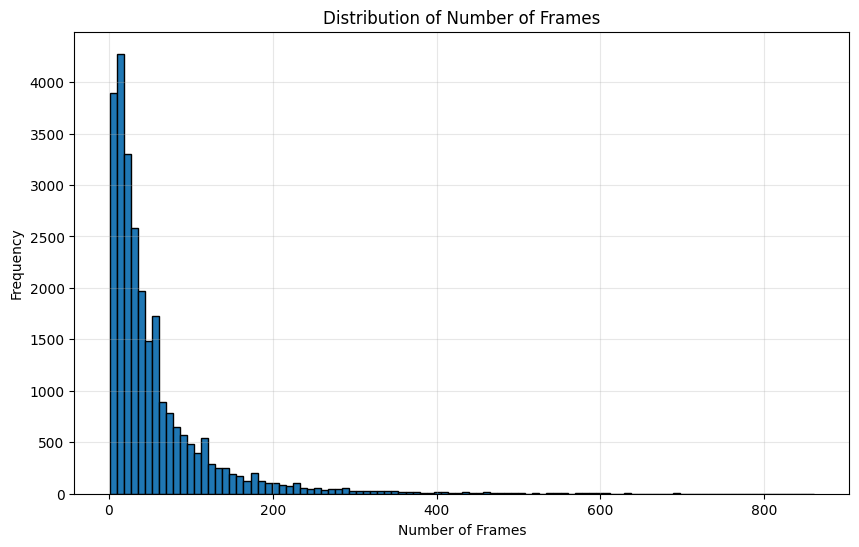

number of frame less 4 sample: 1884
Total samples: 26431
Mean frames: 56.39
Median frames: 33.00
Min frames: 1
Max frames: 861


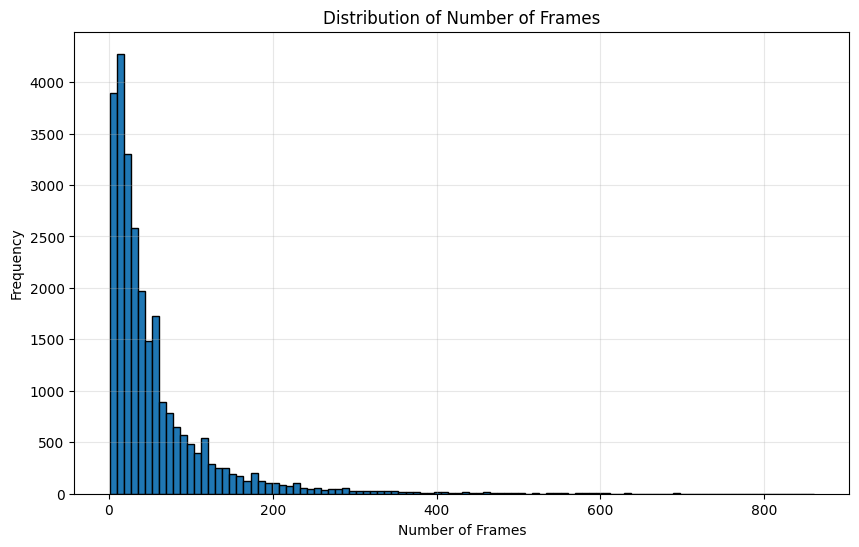

number of frame less 4 sample: 1884
Total samples: 26431
Mean frames: 56.39
Median frames: 33.00
Min frames: 1
Max frames: 861


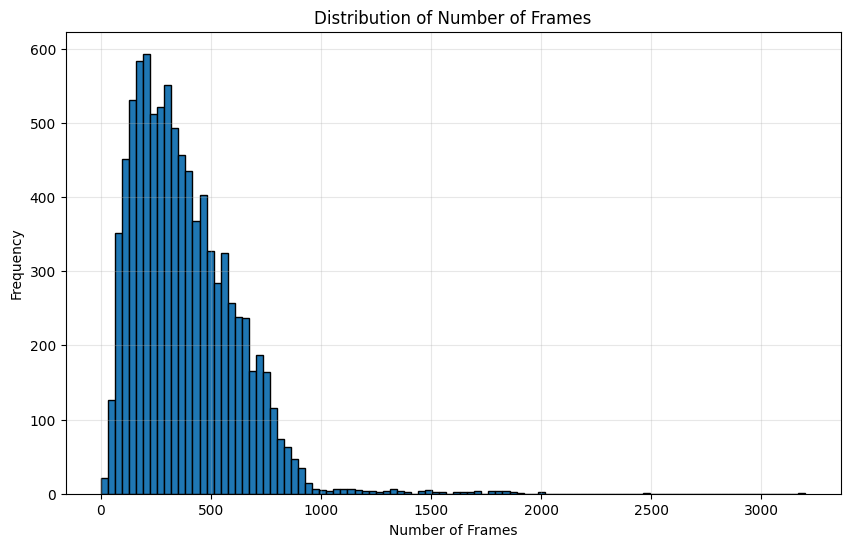

number of frame less 4 sample: 1
Total samples: 9030
Mean frames: 380.20
Median frames: 338.00
Min frames: 1
Max frames: 3201


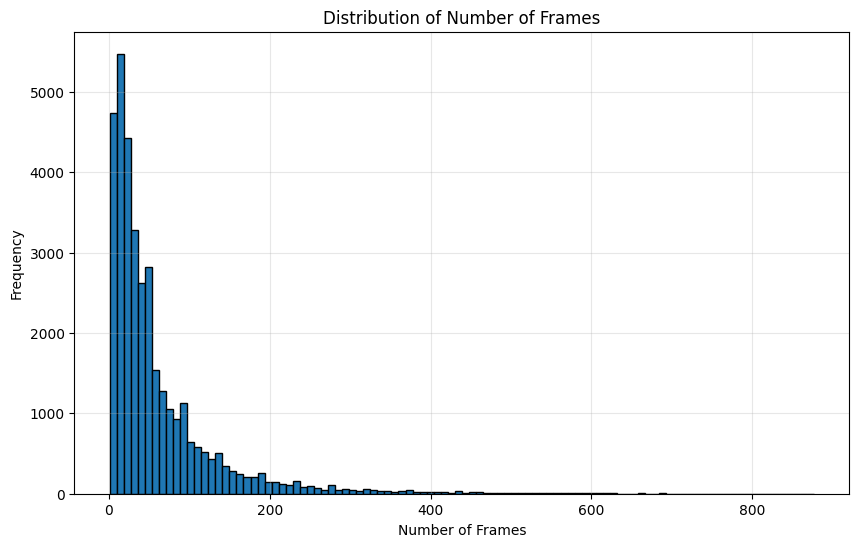

number of frame less 4 sample: 2266
Total samples: 35461
Mean frames: 60.61
Median frames: 33.00
Min frames: 1
Max frames: 877


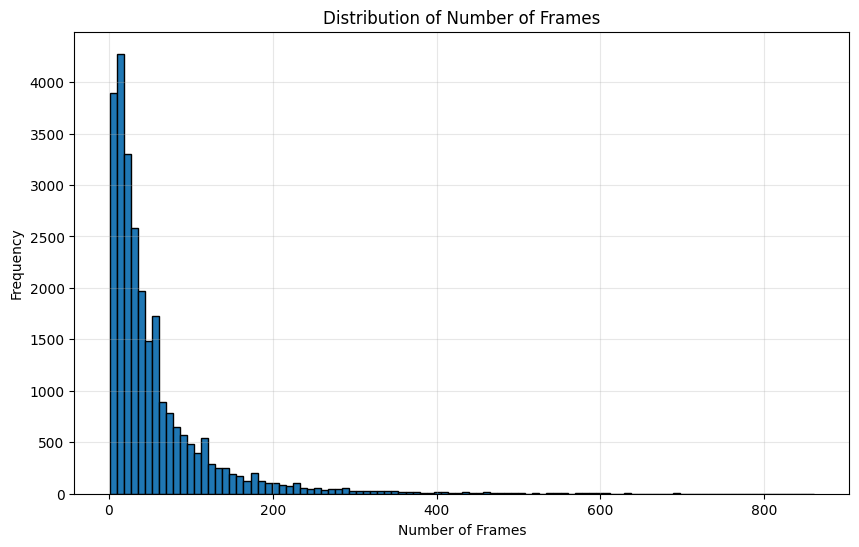

number of frame less 4 sample: 1884
Total samples: 26431
Mean frames: 56.39
Median frames: 33.00
Min frames: 1
Max frames: 861


In [6]:
import torch, json

mode = 'None'
f = None

data_1 = torch.load(f'/2022233235/videollm-online/datasets/coin/COINNext_{mode}_{f}_anno_train.pth')
data_2 = torch.load(f'/2022233235/videollm-online/datasets/coin/COINTaskProcedure_{mode}_{f}_anno_train.pth')
data_3 = torch.load(f'/2022233235/videollm-online/datasets/coin/COINTask_{mode}_{f}_anno_train.pth')
data_4 = torch.load(f'/2022233235/videollm-online/datasets/coin/COINStep_{mode}_{f}_anno_train.pth')    
data_5 = torch.load(f'/2022233235/videollm-online/datasets/coin/COINProcedure_{mode}_{f}_anno_train.pth')

def plot_num_frames_histogram(data):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Extract num_frames from stream messages
    num_frames = []
    for item in data:
        num_f = 0
        for msg in item['conversation']:
            if msg['role'] == 'stream':
                num_f += msg['num_frames']
        num_frames.append(num_f)
    
    # Create histogram
    plt.figure(figsize=(10,6))
    plt.hist(num_frames, bins=100, edgecolor='black')
    plt.title('Distribution of Number of Frames')
    plt.xlabel('Number of Frames')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print some statistics
    print(f"number of frame less 4 sample: {len([f for f in num_frames if f <= 8])}")
    print(f"Total samples: {len(num_frames)}")
    print(f"Mean frames: {np.mean(num_frames):.2f}")
    print(f"Median frames: {np.median(num_frames):.2f}")
    print(f"Min frames: {min(num_frames)}")
    print(f"Max frames: {max(num_frames)}")

plot_num_frames_histogram(data_1)
plot_num_frames_histogram(data_2)
plot_num_frames_histogram(data_3)
plot_num_frames_histogram(data_4)
plot_num_frames_histogram(data_5)






In [40]:
mode = 'simi'
f = 1
data_1 = torch.load(f'/2022233235/videollm-online/datasets/coin/COINNext_{mode}_{f}_anno_train.pth')
print(len(data_1))
print(json.dumps(data_1[1]['conversation'], indent=4))


/tmp/ipykernel_2286907/1964064267.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_1 = torch.load(f'/2022233235/videollm-online/datasets/coin/COINNext_{mode}_{f}_ann

26431
[
    {
        "role": "user",
        "content": "What is the next action for the video? Format your answer concisely. No extra text output."
    },
    {
        "role": "stream",
        "num_frames": 3,
        "learn": true
    },
    {
        "role": "stream_high",
        "num_frames": 1,
        "learn": true
    },
    {
        "role": "assistant",
        "content": "Fall to the ground.",
        "learn": true
    }
]


In [41]:
mode = 'random'
f = None
data_1 = torch.load(f'/2022233235/videollm-online/datasets/coin/COINNext_{mode}_{f}_anno_train.pth')
print(len(data_1))
print(json.dumps(data_1[1]['conversation'], indent=4))

/tmp/ipykernel_2286907/3698624457.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_1 = torch.load(f'/2022233235/videollm-online/datasets/coin/COINNext_{mode}_{f}_ann

26431
[
    {
        "role": "user",
        "content": "What is the next action for the video? Format your answer concisely. No extra text output."
    },
    {
        "role": "stream",
        "num_frames": 4,
        "learn": true
    },
    {
        "role": "stream_high",
        "num_frames": 1,
        "learn": true
    },
    {
        "role": "assistant",
        "content": "Fall to the ground.",
        "learn": true
    }
]


In [1]:
import json
# check question

estp_sqa = json.load(open('/2022233235/datasets/ESTP_IT/estp.json'))
estp_cqa = json.load(open('/2022233235/datasets/ESTP_IT/estp_cqa.json'))

without_q_number = 0
for k,v in estp_sqa.items():
    for kk ,vv in v.items():
        for qa in vv:
            if 'question' not in qa.keys():
                is_query = False
                for msg in qa['conversation']:
                    if msg['role'] == 'User' or msg['role'] == 'user':
                        is_query = True
                        break
                if not is_query:
                    print(qa)
                    without_q_number += 1

print(without_q_number)

without_q_number = 0
for k,v in estp_cqa.items():
    for kk ,vv in v.items():
        for qa in vv:
            if 'question' not in qa.keys():
                is_query = False
                for msg in qa['conversation']:
                    if msg['role'] == 'User' or msg['role'] == 'user':
                        is_query = True
                        break
                if not is_query:
                    print(qa)
                    without_q_number += 1

print(without_q_number)



{'time': [309.37594, 394.28436, 429.69282999999996, 492.58655], 'clip_start_time': 270.0, 'clip_end_time': 570.0, 'Task Type': 'Action Recognition', 'conversation': [{'role': 'assistant', 'content': 'You crochet the grey yarn with a hook.', 'time': 309.37594, 'start_time': 308.8910701749271, 'end_time': 309.8608098250729}, {'role': 'assistant', 'content': 'You crochet the grey yarn with a hook.', 'time': 394.28436, 'start_time': 393.7994901749271, 'end_time': 394.7692298250729}, {'role': 'assistant', 'content': 'You crochet the grey yarn with a hook.', 'time': 429.69282999999996, 'start_time': 429.20796017492705, 'end_time': 430.17769982507286}, {'role': 'assistant', 'content': 'You crochet the grey yarn with the hook.', 'time': 492.58655, 'start_time': 492.1016801749271, 'end_time': 493.0714198250729}]}
{'time': [1400.3178672, 1412.0668571999997], 'clip_start_time': 1350.0210286, 'clip_end_time': 1445.4508726, 'Task Type': 'Action Recognition', 'conversation': [{'role': 'assistant', '

In [3]:
import json
# check time

# estp_sqa = json.load(open('/2022233235/datasets/ESTP_IT/estp.json'))
estp_cqa = json.load(open('/2022233235/datasets/ESTP_IT/estp_cqa.json'))
new_cqa = {}
def find(a):
    without_q_number = 0
    for k,v in a.items():
        for kk ,vv in v.items():
            for qa in vv:
                is_time = True
                if 'clip_start_time' not in qa.keys() and 'start_time' not in qa.keys():
                    is_time = False
                for msg in qa['conversation']:
                    if msg['role'].lower() == 'assistant' and 'start_time' not in msg:
                        is_time = False
                        break
                if not is_time:
                    print(qa['Task Type'])
                    without_q_number += 1
                if is_time:
                    if k not in new_cqa:
                        new_cqa[k] = {}
                    if kk not in new_cqa[k]:
                        new_cqa[k][kk] = []
                    new_cqa[k][kk].append(qa)

    print(without_q_number)
# find(estp_sqa)
find(estp_cqa)

with open('/2022233235/datasets/ESTP_IT/estp_cqa_with_time.json', 'w') as f:
    json.dump(new_cqa, f, indent=2)



Object Relative Context
Object Relative Context
2


: 

In [ ]:
a = {1:0, 2:3}
b = {1:3, 3:4}

# Method 1: Using dict() constructor and | operator (Python 3.9+)
c = dict(a | b)

# Method 2: Using dict() constructor and copy()
# c = dict(a.copy())
# c.update(b)

print(c)
print("Original a:", a)
print("Original b:", b)


TypeError: unsupported operand type(s) for |: 'dict' and 'NoneType'

In [3]:
import torch
import json
annos = torch.load('/2022233235/videollm-online/datasets/ESTP_IT/estp_processed_False__1.pth')
annos = torch.load('/2022233235/videollm-online/datasets/ESTP_IT/estp_cqa_with_time_processed_False__1.pth')
print(json.dumps(annos[1]['conversation'], indent=4))



/tmp/ipykernel_129394/2957227312.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  annos = torch.load('/2022233235/videollm-online/datasets/ESTP_IT/estp_processed_False__1

[
    {
        "role": "stream",
        "num_frames": 1,
        "learn": 0
    },
    {
        "role": "user",
        "content": "I need to start a sewing project. Where should I begin?",
        "time": 30.06463481514165,
        "fps_time": 30.5
    },
    {
        "role": "stream",
        "num_frames": 180,
        "learn": true
    },
    {
        "role": "assistant",
        "content": "The sewing machine is positioned centrally on the wooden table. Begin by threading it using the spool on the right side, and align the fabric under the needle.",
        "time": 120.5,
        "fps_time": 120.5,
        "learn": true
    },
    {
        "role": "stream",
        "num_frames": 96,
        "learn": true
    },
    {
        "role": "user",
        "content": "How can I ensure the design matches the planned sketch?",
        "time": 168.8752579925325,
        "fps_time": 168.5
    },
    {
        "role": "stream",
        "num_frames": 24,
        "learn": true
    },
    {


In [4]:
import json

anno_data = json.load(open('/2022233235/videollm-online/data/estp_dataset/estp_bench_cq_v3.json'))

c = 0
for k,v in anno_data.items():
    for kk, vv in v.items():
        for qa in vv:
            for conv in qa['conversation']:
                if conv['role'].lower() == 'user':
                    c += 1

print(c)


1052


In [8]:
import json,os
import numpy as np

def load_multiple_json(file_path):
    """读取包含多个 JSON 对象的文件，并将每个 JSON 对象解析成 Python 对象，存放在列表中。"""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    decoder = json.JSONDecoder()
    pos = 0
    results = []
    content_length = len(content)
    
    while pos < content_length:
        # 跳过空白字符
        while pos < content_length and content[pos].isspace():
            pos += 1
        if pos >= content_length:
            break
        try:
            obj, new_pos = decoder.raw_decode(content, pos)
            results.append(obj)
            pos = new_pos
        except json.JSONDecodeError as e:
            # 出现解析错误则退出循环
            print(f"JSON 解析错误: {e}")
            break
    return results


def result2dict(eval_result):
    result_dict1 = {}
    result_dict2 = {}
    
    for result in eval_result:
        if result['video_uid'] not in result_dict1:
            result_dict1[result['video_uid']] = {}
            result_dict2[result['video_uid']] = {}
        if result['clip_uid'] not in result_dict1[result['video_uid']]:
            result_dict1[result['video_uid']][result['clip_uid']] = 0
            result_dict2[result['video_uid']][result['clip_uid']] = []
        result_dict1[result['video_uid']][result['clip_uid']] += 1
        result_dict2[result['video_uid']][result['clip_uid']].append(result)
    return result_dict1, result_dict2

eval_file = '/2022233235/videollm-online/data/estp_dataset/estpCqa_ours/LivebaseStage2.5evaluator_deepseek_1_2.json'

parent_dir = os.path.dirname(eval_file)
eval_files = [os.path.join(parent_dir, f) for f in os.listdir(parent_dir) if f.startswith(eval_file.split('/')[-1])]
eval_result = []
for eval_file in eval_files:
    eval_result += load_multiple_json(eval_file)

result_dict1, result_dict1_2 = result2dict(eval_result)

eval_file = '/2022233235/videollm-online/data/estp_dataset/estpCqa_ours/LivebaseStage3.5_high0.31_11evaluator_deepseek_1_2.json'

parent_dir = os.path.dirname(eval_file)
eval_files = [os.path.join(parent_dir, f) for f in os.listdir(parent_dir) if f.startswith(eval_file.split('/')[-1])]
eval_result = []
for eval_file in eval_files:
    eval_result += load_multiple_json(eval_file)

result_dict2, result_dict2_2 = result2dict(eval_result)


# Compare the two dictionaries and find differences
differences = {}

# Check for video_uids in result_dict1 but not in result_dict2
for video_uid in result_dict1:
    if video_uid not in result_dict2:
        if video_uid not in differences:
            differences[video_uid] = {}
        for clip_uid, count in result_dict1[video_uid].items():
            differences[video_uid][clip_uid] = (count, 0)
    else:
        # Check for clip_uids in result_dict1 but not in result_dict2
        for clip_uid, count in result_dict1[video_uid].items():
            if clip_uid not in result_dict2[video_uid]:
                if video_uid not in differences:
                    differences[video_uid] = {}
                differences[video_uid][clip_uid] = (count, 0)
            # Check for different counts for the same clip_uid
            elif count != result_dict2[video_uid][clip_uid]:
                if video_uid not in differences:
                    differences[video_uid] = {}
                differences[video_uid][clip_uid] = (count, result_dict2[video_uid][clip_uid])

# Check for video_uids in result_dict2 but not in result_dict1
for video_uid in result_dict2:
    if video_uid not in result_dict1:
        if video_uid not in differences:
            differences[video_uid] = {}
        for clip_uid, count in result_dict2[video_uid].items():
            differences[video_uid][clip_uid] = (0, count)
    else:
        # Check for clip_uids in result_dict2 but not in result_dict1
        for clip_uid, count in result_dict2[video_uid].items():
            if clip_uid not in result_dict1[video_uid]:
                if video_uid not in differences:
                    differences[video_uid] = {}
                differences[video_uid][clip_uid] = (0, count)

# Print the differences
print("Differences between the two dictionaries:")
print("Format: video_uid -> clip_uid -> (count in dict1, count in dict2)")
for video_uid, clips in differences.items():
    print(f"Video UID: {video_uid}")
    for clip_uid, counts in clips.items():
        print(f"  Clip UID: {clip_uid} -> {counts}")





Differences between the two dictionaries:
Format: video_uid -> clip_uid -> (count in dict1, count in dict2)
Video UID: 4ce9f93b-f44c-46fe-9050-3452d2f39abb
  Clip UID: 0aa3ed50-16dc-4367-a65e-edb57e606315 -> (2, 4)
  Clip UID: f4ff96e7-9e67-409d-b0ea-b975719ec594 -> (3, 6)
Video UID: 5825062f-4827-407c-bbd3-91ca010d25c2
  Clip UID: de131ad9-7b40-402c-b6d9-8fb665ac76e7 -> (2, 4)
  Clip UID: e3caccbb-913e-4353-a89e-15fc8eaf7e19 -> (2, 4)
  Clip UID: 102e7e39-f30e-4fcf-91a9-241476c05c20 -> (3, 6)
Video UID: 2d1bf98e-a133-4f63-bc1d-91f718078a52
  Clip UID: c755bac4-9a6a-41be-84df-db42b73d7ff7 -> (2, 4)
Video UID: 0daaa66c-fb5f-4680-b84c-2f65f0f0bd9b
  Clip UID: 214084be-c6ae-4653-9d50-f6d586ec050f -> (2, 4)
Video UID: 368e4468-1f75-4cdb-a9d0-9b8982a3cbef
  Clip UID: 871d088d-5032-48f2-ad0f-3f3366e3ee11 -> (2, 4)
Video UID: 50c1df1c-e016-472a-b0ac-d297b0c82e87
  Clip UID: 4a0524b9-2f9f-45cd-b738-c5210b6ba40e -> (2, 4)
Video UID: 79b9f7e3-f1ce-4838-9887-1deeba08e600
  Clip UID: af255a62-dd4d

In [12]:

video_uid = "grp-304735ba-6bf5-4d39-bcb5-0dabddb11d68"
clip_uid = 'goal_step'

print(len(result_dict1_2[video_uid][clip_uid]))
print(len(result_dict2_2[video_uid][clip_uid]))
json.dump(result_dict1_2[video_uid][clip_uid], open('temp1.json', 'w'), indent=4)
json.dump(result_dict2_2[video_uid][clip_uid], open('temp2.json', 'w'), indent=4)

3
4


In [14]:
import torch

a = torch.load('/2022233235/videollm-online/datasets/ESTP_IT/estp_cqa_with_time_processed_True_high_1.pth')
print(len(a))

/tmp/ipykernel_129394/474538760.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a = torch.load('/2022233235/videollm-online/datasets/ESTP_IT/estp_cqa_with_time_processed

20229


In [ ]:
EGO_ANNO_ROOT = '/2022233235/datasets/ego4d/annotations'
EGO4D_JSON_PATH = "/2022233235/datasets/ego4d/ego4d.json"
PROJECT_ROOT = '/2022233235/videollm-online'
fileter_data_path = f'{EGO_ANNO_ROOT}/filtered_data.json'


import json, os


In [ ]:
def add_timestamp_and_text_overlay(video_path, timestamps, texts, output_path, start_time=None, end_time=None):
    """
    Add timestamp and text overlay to video with sci-fi style UI inspired by SpaceX interface
    
    Args:
        video_path: Path to input video
        timestamps: List of timestamps in seconds
        texts: List of texts to display at corresponding timestamps
        output_path: Path to save output video
        start_time: Start time in seconds (if None, use 0)
        end_time: End time in seconds (if None, use video duration)
    """
    import cv2
    import numpy as np
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_duration = total_frames / fps
    
    # Set default start and end times
    if start_time is None:
        start_time = 0
    if end_time is None:
        end_time = video_duration
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Convert timestamps to frame numbers
    timestamp_frames = [int(ts * fps) for ts in timestamps]
    
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Calculate current time in video
        current_video_time = frame_count / fps
        
        # Calculate adjusted time based on start_time and end_time
        # Map the video frames to the specified time range
        time_progress = frame_count / total_frames  # Progress through video (0 to 1)
        adjusted_time = start_time + (end_time - start_time) * time_progress
        
        # Create top-left timestamp panel (Enhanced sci-fi style)
        panel_width = 320
        panel_height = 80
        panel = np.zeros((panel_height, panel_width, 3), dtype=np.uint8)
        
        # Gradient background for depth
        for i in range(panel_height):
            alpha = i / panel_height
            panel[i, :] = [int(5 + alpha * 15), int(10 + alpha * 25), int(35 + alpha * 20)]  # Dark blue gradient
        
        # Add holographic-style borders with cyan and magenta accents
        cv2.rectangle(panel, (0, 0), (panel_width-1, panel_height-1), (255, 200, 0), 2)  # Bright cyan border
        cv2.rectangle(panel, (2, 2), (panel_width-3, panel_height-3), (255, 100, 255), 1)   # Magenta inner border
        
        # Add animated corner elements
        corner_offset = int((frame_count * 0.1) % 10)
        cv2.line(panel, (corner_offset, 0), (corner_offset + 15, 0), (0, 255, 255), 2)  # Animated top line
        cv2.line(panel, (panel_width - corner_offset - 15, panel_height-1), (panel_width - corner_offset, panel_height-1), (0, 255, 255), 2)  # Animated bottom line
        
        # Add holographic grid pattern
        for i in range(0, panel_width, 20):
            cv2.line(panel, (i, 0), (i, panel_height), (0, 100, 150), 1)
        for i in range(0, panel_height, 15):
            cv2.line(panel, (0, i), (panel_width, i), (0, 100, 150), 1)
        
        # Add timestamp with futuristic font styling
        timestamp_text = f"T+{adjusted_time:06.1f}"
        # Add glow effect
        cv2.putText(panel, timestamp_text, (18, 45), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.0, (100, 255, 255), 4)  # Glow
        cv2.putText(panel, timestamp_text, (15, 42), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)    # Main text
        
        # Add status indicators with pulsing effect
        pulse = int(127 + 128 * np.sin(frame_count * 0.2))
        cv2.circle(panel, (panel_width - 30, 25), 6, (0, pulse, 255), -1)  # Pulsing blue dot
        cv2.circle(panel, (panel_width - 30, 25), 8, (0, 255, 255), 1)    # Outer ring
        
        # Add "ONLINE" text
        cv2.putText(panel, "ONLINE", (panel_width - 80, 65), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 100), 1)
        
        # Overlay timestamp panel on top-left of frame
        frame[15:15+panel_height, 15:15+panel_width] = panel
        
        # Add text overlay if current frame matches any timestamp
        active_text = None
        for i, ts_frame in enumerate(timestamp_frames):
            if abs(frame_count - ts_frame) <= fps * 2.0:  # Show text for 2.0 seconds
                active_text = texts[i]
                break
        
        if active_text:
            # Create main text panel at bottom with enhanced sci-fi styling
            text_panel_height = 160
            text_panel = np.zeros((text_panel_height, width, 3), dtype=np.uint8)
            
            # Create gradient background
            for i in range(text_panel_height):
                alpha = (text_panel_height - i) / text_panel_height
                text_panel[i, :] = [int(5 + alpha * 20), int(15 + alpha * 30), int(40 + alpha * 25)]
            
            # Add animated scan lines
            scan_line_pos = int((frame_count * 2) % text_panel_height)
            cv2.line(text_panel, (0, scan_line_pos), (width, scan_line_pos), (0, 255, 255), 1)
            
            # Add top border with multiple layers
            cv2.line(text_panel, (0, 0), (width, 0), (0, 255, 255), 4)  # Bright cyan top line
            cv2.line(text_panel, (0, 4), (width, 4), (255, 100, 255), 2)  # Magenta secondary line
            cv2.line(text_panel, (0, 7), (width, 7), (100, 200, 255), 1)  # Light blue tertiary line
            
            # Add hexagonal pattern overlay
            for x in range(0, width, 40):
                for y in range(0, text_panel_height, 30):
                    if (x + y) % 80 == 0:
                        cv2.circle(text_panel, (x, y), 3, (0, 100, 150), 1)
            
            # Split long text into multiple lines
            words = active_text.split()
            lines = []
            current_line = ""
            max_chars_per_line = 65
            
            for word in words:
                if len(current_line + " " + word) < max_chars_per_line:
                    current_line += " " + word if current_line else word
                else:
                    lines.append(current_line)
                    current_line = word
            if current_line:
                lines.append(current_line)
            
            # Display text lines with enhanced holographic styling
            text_start_y = 50
            for j, line in enumerate(lines):
                y_pos = text_start_y + j * 40
                if y_pos < text_panel_height - 20:
                    # Add multiple shadow layers for depth
                    cv2.putText(text_panel, line, (45, y_pos + 3), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 0), 5)      # Deep shadow
                    cv2.putText(text_panel, line, (43, y_pos + 1), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 50, 100), 3)   # Blue shadow
                    cv2.putText(text_panel, line, (42, y_pos), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.1, (100, 255, 255), 3) # Cyan glow
                    cv2.putText(text_panel, line, (40, y_pos), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255, 255, 255), 2) # Main white text
            
            # Add side accent bars with animated elements
            bar_width = 12
            # Left bar with gradient
            for i in range(text_panel_height):
                alpha = i / text_panel_height
                color = [int(alpha * 255), int(255 - alpha * 155), 255]
                cv2.rectangle(text_panel, (0, i), (bar_width, i+1), color, -1)
            
            # Right bar with gradient
            for i in range(text_panel_height):
                alpha = i / text_panel_height
                color = [255, int(alpha * 200), int(255 - alpha * 155)]
                cv2.rectangle(text_panel, (width-bar_width, i), (width, i+1), color, -1)
            
            # Add animated pulse lines on side bars
            pulse_pos = int((frame_count * 3) % text_panel_height)
            cv2.line(text_panel, (0, pulse_pos), (bar_width, pulse_pos), (255, 255, 255), 2)
            cv2.line(text_panel, (width-bar_width, pulse_pos), (width, pulse_pos), (255, 255, 255), 2)
            
            # Overlay text panel at bottom of frame
            frame[height-text_panel_height:height, :] = text_panel
        
        # Add enhanced corner UI elements with animated effects
        corner_size = 35
        corner_thickness = 3
        
        # Animated corner brackets with cyan and magenta
        offset = int((frame_count * 0.15) % 5)
        
        # Top corners with animated glow
        cv2.line(frame, (offset, offset), (corner_size + offset, offset), (0, 255, 255), corner_thickness + 1)
        cv2.line(frame, (offset, offset), (offset, corner_size + offset), (0, 255, 255), corner_thickness + 1)
        cv2.line(frame, (width-corner_size-offset, offset), (width-1-offset, offset), (255, 100, 255), corner_thickness + 1)
        cv2.line(frame, (width-1-offset, offset), (width-1-offset, corner_size + offset), (255, 100, 255), corner_thickness + 1)
        
        # Bottom corners with animated glow
        cv2.line(frame, (offset, height-corner_size-offset), (offset, height-1-offset), (255, 100, 255), corner_thickness + 1)
        cv2.line(frame, (offset, height-1-offset), (corner_size + offset, height-1-offset), (255, 100, 255), corner_thickness + 1)
        cv2.line(frame, (width-corner_size-offset, height-1-offset), (width-1-offset, height-1-offset), (0, 255, 255), corner_thickness + 1)
        cv2.line(frame, (width-1-offset, height-corner_size-offset), (width-1-offset, height-1-offset), (0, 255, 255), corner_thickness + 1)
        
        # Add small corner dots for extra detail
        cv2.circle(frame, (corner_size + 5, corner_size + 5), 3, (255, 255, 0), -1)
        cv2.circle(frame, (width - corner_size - 5, corner_size + 5), 3, (255, 255, 0), -1)
        cv2.circle(frame, (corner_size + 5, height - corner_size - 5), 3, (255, 255, 0), -1)
        cv2.circle(frame, (width - corner_size - 5, height - corner_size - 5), 3, (255, 255, 0), -1)
        
        # Add subtle scan line effect across entire frame
        if frame_count % 60 < 30:  # Intermittent scan line
            scan_y = int((frame_count * 5) % height)
            cv2.line(frame, (0, scan_y), (width, scan_y), (0, 255, 255), 1)
        
        out.write(frame)
        frame_count += 1
    
    cap.release()
    out.release()
    print(f"Enhanced sci-fi video overlay saved to: {output_path}")
    print(f"Time mapping: Video duration {video_duration:.3f}s mapped to {start_time:.3f}s - {end_time:.3f}s")

# Example usage with the current QA data
d = {1:(0,30),2:(30,60+26),3:(60+26,120),4:(120,143),5:(143,3*60+49),7:(4*60,4*60+50)}
for k,v in d.items():
    video_path = f"/root/videollm-online/visualize/temp_video/{k}.mp4"
    start_time,end_time = v
    
    if 'qa' in locals() and 'video_path' in locals():
        # Extract timestamps and texts from conversation
        timestamps = []
        texts = []
        video_name = video_path.split('/')[-1]
        
        # Create output video with overlay
        output_video_path = f"/root/videollm-online/visualize/temp_video/{video_name.split('.')[0]}_processed.mp4"
        add_timestamp_and_text_overlay(video_path, timestamps, texts, output_video_path, start_time, end_time)


In [6]:
from decord import VideoReader

vr = VideoReader('/2022233235/.cache/huggingface/hub/datasets--lmms-lab--LLaVA-Video-178K/snapshots/6d8c562dc26d70042a0d9704d1cae58c94b89098/1_2_m_activitynetqa/ActivityNet-QA/activitynet/train/v_znhZPUF6xQw.mp4', num_threads=2)
vr.get_frame_timestamp(0)
video_pts = vr._frame_pts[:,1]
print((int(video_pts[-1])))

75


In [1]:
def generate_seek_index(jsonl_path):
    lines = open(jsonl_path).readlines()
    seeks = [0] + torch.tensor([len(l) for l in lines]).cumsum(dim=-1)[:-1].tolist()
    with open(jsonl_path, 'a') as f:
        f.write(json.dumps(seeks))
        
# 生成seek索引
import json,os, torch
output_file_path = '/2022233235/videollm-online/EyeWO2/data/llava_video_178k_with_seeks_sample_valid.jsonl'
generate_seek_index(output_file_path)

In [7]:
a = """ EPM: 173/297=0.5824915824915825
HLD: 172/186=0.9247311827956989
ASI: 78/148=0.527027027027027
STU: 76/178=0.42696629213483145
OJR: 109/184=0.592391304347826
ATR: 75/116=0.646551724137931
FPD: 68/101=0.6732673267326733
ACR: 47/109=0.43119266055045874
OCR: 106/149=0.7114093959731543
CRR: 130/240=0.5416666666666666
SSR: 412/629=0.6550079491255962
REC: 241/698=0.3452722063037249"""

a = a.split('\n')
print(a)
a = [float(i.split('=')[1]) for i in a]


# compute mean accuracy
mean_accuracy = sum(a) / len(a)
print(mean_accuracy)

[' EPM: 173/297=0.5824915824915825', 'HLD: 172/186=0.9247311827956989', 'ASI: 78/148=0.527027027027027', 'STU: 76/178=0.42696629213483145', 'OJR: 109/184=0.592391304347826', 'ATR: 75/116=0.646551724137931', 'FPD: 68/101=0.6732673267326733', 'ACR: 47/109=0.43119266055045874', 'OCR: 106/149=0.7114093959731543', 'CRR: 130/240=0.5416666666666666', 'SSR: 412/629=0.6550079491255962', 'REC: 241/698=0.3452722063037249']
0.5881646098572643


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# 假设这是一个三分类问题
num_classes = 3

# 模拟模型的输出：
# logits 是模型对每个类别的原始分数，通常在通过 softmax 之前
# 假设模型预测第3个类别的分数最高
logits = torch.tensor([[1.0, 2.0, 5.0]], requires_grad=True)

# 模拟真实标签
# 在 PyTorch 的 CrossEntropyLoss 中，硬标签通常是类别的索引
true_label_index = torch.tensor([2])  # 类别2是正确答案

# 定义一个类别权重，例如将类别2的权重设置为0.7
class_weights = torch.tensor([0.0, 0.0, 0.7])


# --- 方法一：使用修改后的标签来应用权重（你的提问形式） ---
print("--- 方法一：通过修改标签值来应用权重 ---")

# 创建一个修改后的“软标签”，但本质上是加权过的硬标签
# 注意：这在 PyTorch 的 CrossEntropyLoss 中不直接工作，因为该损失函数期望的是索引。
# 我们可以手动计算损失来模拟这个过程
# 1. 对 logits 进行 softmax 得到概率分布
probs = nn.functional.softmax(logits, dim=1)
print(f"模型预测的概率分布 (softmax):\n{probs}")

# 2. 创建加权标签
# 创建一个 one-hot 编码的硬标签
one_hot_label = nn.functional.one_hot(true_label_index, num_classes=num_classes).float()
print(f"原始的 one-hot 标签:\n{one_hot_label}")

# 将正确类别的标签值从1修改为0.7
weighted_label = one_hot_label.clone()
weighted_label[0, true_label_index] = 0.7
print(f"修改后的加权标签:\n{weighted_label}")

# 3. 手动计算交叉熵损失
# PyTorch 的 CrossEntropyLoss 内部会对 logits 自动进行 log_softmax
loss_manual = nn.CrossEntropyLoss(reduction='none')(logits, weighted_label, )

print(f"通过修改标签值计算的损失: {loss_manual.item()}")

# --- 方法二：使用 CrossEntropyLoss 的 weight 参数 ---
print("\n--- 方法二：使用损失函数的 'weight' 参数 ---")

# 创建 CrossEntropyLoss 实例，并传入类别权重
loss_function_with_weight = nn.CrossEntropyLoss(weight=class_weights, reduction='none')

# 计算损失。PyTorch 的 CrossEntropyLoss 期望 logits 和硬标签索引
loss_weighted = loss_function_with_weight(logits, true_label_index)

print(f"使用 CrossEntropyLoss 的 'weight' 参数计算的损失: {loss_weighted.item()}")

# --- 比较结果 ---
print("\n--- 比较结果 ---")
# 检查两个损失值是否非常接近
if torch.isclose(loss_manual, loss_weighted):
    print("两个损失值相等，证明这两种方法在数学上是等价的。")
else:
    print("两个损失值不相等，存在差异。")

--- 方法一：通过修改标签值来应用权重 ---
模型预测的概率分布 (softmax):
tensor([[0.0171, 0.0466, 0.9362]], grad_fn=<SoftmaxBackward0>)
原始的 one-hot 标签:
tensor([[0., 0., 1.]])
修改后的加权标签:
tensor([[0.0000, 0.0000, 0.7000]])
通过修改标签值计算的损失: 0.046118736267089844

--- 方法二：使用损失函数的 'weight' 参数 ---
使用 CrossEntropyLoss 的 'weight' 参数计算的损失: 0.046118736267089844

--- 比较结果 ---
两个损失值相等，证明这两种方法在数学上是等价的。


In [2]:
import os
import json

# 设置目标目录
folder = '/2024233235/videollm-online/datasets/ESTP_IT/full_scale_2fps_max384/'
# 获取目录下所有文件名（排除隐藏文件和文件夹，仅保留文件）
files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and not f.startswith('.')]


# 输出保存位置
out_path = '/2024233235/videollm-online/datasets/ESTP_IT/full_scale_2fps_max384_files.json'
with open(out_path, 'w') as f:
    json.dump(files, f, indent=4)

print(f"已将 {len(files)} 个文件名保存到 {out_path}")


已将 1184 个文件名保存到 /2024233235/videollm-online/datasets/ESTP_IT/full_scale_2fps_max384_files.json
